In [20]:
import os
import numpy as np
import ipynb
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from scipy.stats import levene, wilcoxon
from cliffs_delta import cliffs_delta
from ipynb.fs.defs.functions_and_classes import Dataset, Datapoint
from ipynb.fs.defs.functions_and_classes import build_dict_from_vector_file, display_embedding_properties, load_dataset_from_csv

In [21]:
model = 'word2vec'
dim = 25
language = 'he'
mode = 'best'
ref = 'noun'

In [22]:
fname = f'{model}_{dim}_{language}_vectors_reduced.txt'
embedding = build_dict_from_vector_file('./models/reduced/', fname)
dataset = load_dataset_from_csv('./hebrew dataset/definitive_dataset.csv')
dataset.filter_against_embedding(embedding)

Processed 0 / 140 entries
Embedding entries: 140
Embedding dimension: 10
Number of datapoints before adjustment: 55
Number of datapoints after adjustment: 29


In [4]:
triplets = dataset.get_triplets()
print(triplets)

[['מחשב', 'למחשב', ['לחשב', 'להתחשב', 'לחשוב', 'להחשיב', 'להיחשב']], ['תחזוקה', 'לתחזק', ['לחזק', 'להתחזק', 'להחזיק']], ['תקשורת', 'לתקשר', ['לקשר', 'להתקשר', 'לקשור', 'להיקשר']], ['תפקידים', 'לתפקד', ['לפקד', 'להתפקד', 'לפקוד', 'להפקיד', 'להיפקד']], ['תרגילים', 'לתרגל', ['לרגל', 'להתרגל', 'להרגיל']], ['תזמורת', 'לתזמר', ['לזמר']], ['תזמון', 'לתזמן', ['לזמן', 'להזדמן', 'להזמין']], ['סקרנים', 'לסקרן', ['לסקר', 'לסקור', 'להיסקר']], ['סקרנים', 'להסתקרן', ['לסקר', 'לסקור', 'להיסקר']], ['מלכודת', 'למלכד', ['ללכד', 'להתלכד', 'ללכוד', 'להילכד']], ['אבטחה', 'לאבטח', ['לבטח', 'לבטוח', 'להבטיח']], ['מסגרת', 'למסגר', ['להסתגר', 'לסגור', 'להסגיר', 'להיסגר']], ['תעתיקים', 'לתעתק', ['להעתיק']], ['תמריצים', 'לתמרץ', ['להמריץ']], ['תצפית', 'לתצפת', ['לצפות']], ['אבחנות', 'לאבחן', ['לבחון', 'להבחין', 'להיבחן']], ['תחקיר', 'לתחקר', ['לחקור', 'להיחקר']], ['תקליטים', 'לתקלט', ['לקלוט', 'להקליט', 'להיקלט']], ['אזכרות', 'לאזכר', ['לזכור', 'להזכיר', 'להיזכר']], ['מספר', 'למספר', ['לספר', 'להסתפר', 'לספור', '

In [24]:
def compute_similarities(embedding, triplets, mode='mean', ref='noun'):
    """ If ref is 'noun', we collect noun/denominal and noun/other verb sims;
    if ref is 'denominal' we collect denominal/noun and denominal/other verb sims."""

    sims_n_dn = []
    sims_ref_ndn = []
    best_ndns = []
    for triplet in triplets:
        print(triplet)
        n = triplet[0]
        dn = triplet[1]
        ndns = triplet[2] #DO WE ALSO CONSIDER THE OTHER ROOT DERIVED ELEMENTS????
        
        sim_n_dn = 1 - cosine(embedding[n], embedding[dn])
        sims_n_dn.append(sim_n_dn)
        
        
        if ref =='noun':
            reference = n
        if ref == 'denominal':
            reference = dn
            
        if mode == 'best':
            index_best_ndn = np.argmax([1 - cosine(embedding[reference], embedding[ndn]) for ndn in ndns])
            best_ndn = ndns[index_best_ndn]
            best_ndn_vec = embedding[best_ndn]
            best_ndns.append(best_ndn)
            sim_ref_ndn = 1 - cosine(embedding[reference], best_ndn_vec)

        if mode == 'mean':
            #other_vec = np.mean([embedding[other_verb] for other_verb in other_verbs], axis=0)
            sim_ref_ndn = np.mean([1 - cosine(embedding[reference], embedding[ndn]) for ndn in ndns], axis=0)

        sims_ref_ndn.append(sim_ref_ndn)
        
    """for datapoint in dataset:
        noun = datapoint['noun']
        denominals = filter_empty_words(datapoint['denom'])
        non_denominals = filter_empty_words(datapoint['non_denom'])
        other_non_denominals = filter_empty_words(datapoint['others'])
        other_verbs = non_denominals+other_non_denominals

        for denominal in denominals:
            sim_n_dn = 1 - spatial.distance.cosine(embedding[noun], embedding[denominal])
            sims_n_dn.append(sim_n_dn)

            if ref =='noun':
                reference = noun
            if ref == 'denominal':
                reference = denominal

            if mode == 'best':
                index_best_ov = np.argmax([1 - spatial.distance.cosine(embedding[reference], embedding[other_verb]) for other_verb in other_verbs])
                best_ov = other_verbs[index_best_ov]
                other_vec = embedding[best_ov]
                triplets.append((noun, denominal, best_ov))
                sim_ref_other = 1 - spatial.distance.cosine(embedding[reference], other_vec)

            if mode == 'mean':
                #other_vec = np.mean([embedding[other_verb] for other_verb in other_verbs], axis=0)
                sim_ref_other = np.mean([1 - spatial.distance.cosine(embedding[reference], embedding[other_verb]) for other_verb in other_verbs], axis=0)

            sims_ref_ov.append(sim_ref_other)"""

    return (sims_n_dn, sims_ref_ndn, best_ndns)

In [25]:
sims_n_dn, sims_ref_ndn, best_ndns = compute_similarities(embedding, triplets, mode=mode, ref=ref)

NameError: name 'mode' is not defined

['לחשב',
 'להחזיק',
 'לקשר',
 'להתפקד',
 'לרגל',
 'לזמר',
 'לזמן',
 'לסקר',
 'לסקר',
 'ללכוד',
 'להבטיח',
 'להיסגר',
 'להעתיק',
 'להמריץ',
 'לצפות',
 'להבחין',
 'להיחקר',
 'להקליט',
 'להזכיר',
 'להיספר',
 'להתרפק',
 'לסמור',
 'לזרוח',
 'לזרוח',
 'לגמול',
 'לצלוח',
 'לשכן',
 'לגבור',
 'להסמיך',
 'לארוך',
 'להגדיר']

In [18]:
def test_diff(sims_n_dn, sims_ref_ndn):
    diff_sims_dn_ndn = np.array(sims_n_dn) - np.array(sims_ref_ndn)
    print(f'Sample size: {len(diff_sims_dn_ndn)}')
    plt.hist(diff_sims_dn_ndn)
    plt.show()

    print(f'Standard deviation: {np.std(diff_sims_dn_ndn)}')
    print(f'Mean: {np.mean(diff_sims_dn_ndn)}')

    _, p = levene(sims_n_dn, sims_ref_ndn)
    if p > .05:
        print("F-test failed, performing Wilcoxon")
        print(f'Levene p: {p}')
        print(wilcoxon(sims_n_dn, sims_ref_ndn, zero_method='wilcox', correction=False, alternative='greater'))
        z, p = wilcoxon(sims_n_dn, sims_ref_ndn, zero_method='wilcox', correction=False, alternative='greater')
        z2, p2 = wilcoxon(sims_n_dn, sims_ref_ndn, zero_method='wilcox', correction=False)
        print(z2)
        print(z2/np.sqrt(len(sims_n_dn)+len(sims_ref_ndn)))
        d, res = cliffs_delta(sims_n_dn, sims_ref_ndn)
        print(d,res)
    else:
        print("F-test succeeded, performing t-test")
        print(f'Levene p: {p}')
        print(ttest_rel(sims_n_dn, sims_ref_ndn)) 
        
    return diff_sims_dn_ndn 

Sample size: 31


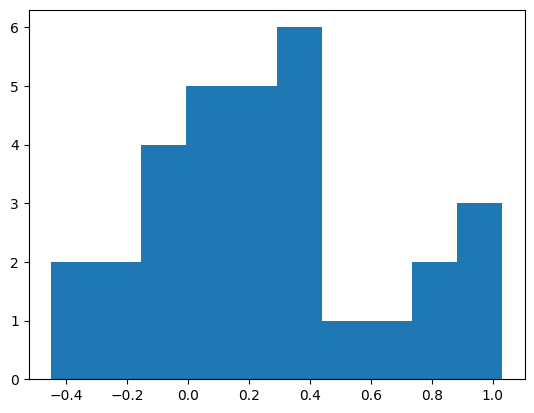

Standard deviation: 0.3893805301775175
Mean: 0.25715682232872455
F-test failed, performing Wilcoxon
Levene p: 0.6874429510756478
WilcoxonResult(statistic=402.0, pvalue=0.0009266980923712254)
94.0
11.938011938017906
0.4422476586888658 medium


array([ 0.40259086,  0.20726695,  0.03391621, -0.19178249,  0.25064108,
       -0.44836858,  0.81458326, -0.28653195,  0.11423936, -0.41437543,
        0.33289706, -0.11475045,  0.77570231,  0.38908602,  0.54164927,
        0.22440609, -0.08372843,  0.11110028,  0.07091506,  0.23013383,
        0.35165883,  0.0724098 ,  1.01280692,  1.03063802, -0.11256178,
        0.95193628,  0.20791436,  0.36732286,  0.42340993, -0.01529531,
        0.72203128])

In [23]:
test_diff(sims_n_dn, sims_ref_ndn)